# Instruction Finetuning a LLM

### Stages 
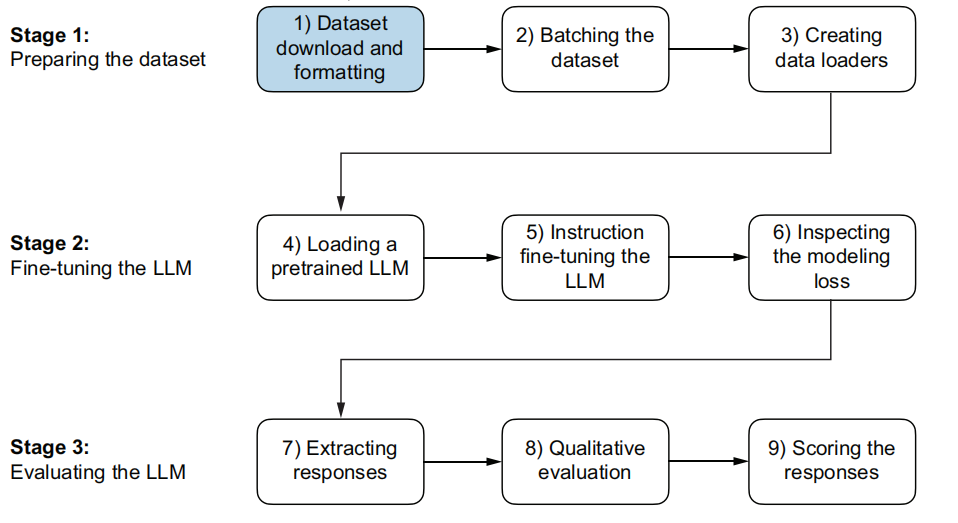

### Downloading the dataset

In [47]:
import json
import os
import urllib
def download_and_load_file(file_path, url):
    if not os.path.exists(file_path):
        with urllib.request.urlopen(url) as response:
            text_data = response.read().decode("utf-8")
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)
    else: 
        with open(file_path, "r", encoding="utf-8") as file:
            text_data = file.read()
    with open(file_path, "r") as file:
        data = json.load(file)
    return data

file_path = "instruction-data.json"
url = (
"https://raw.githubusercontent.com/rasbt/LLMs-from-scratch"
"/main/ch07/01_main-chapter-code/instruction-data.json"
)
data = download_and_load_file(file_path, url)
print("Number of entries:", len(data))

Number of entries: 1100


In [48]:
print("Example entry:\n", data[50])

Example entry:
 {'instruction': 'Identify the correct spelling of the following word.', 'input': 'Ocassion', 'output': "The correct spelling is 'Occasion.'"}


In [49]:
print("Another example entry:\n", data[999])

Another example entry:
 {'instruction': "What is an antonym of 'complicated'?", 'input': '', 'output': "An antonym of 'complicated' is 'simple'."}


## Prompt designing
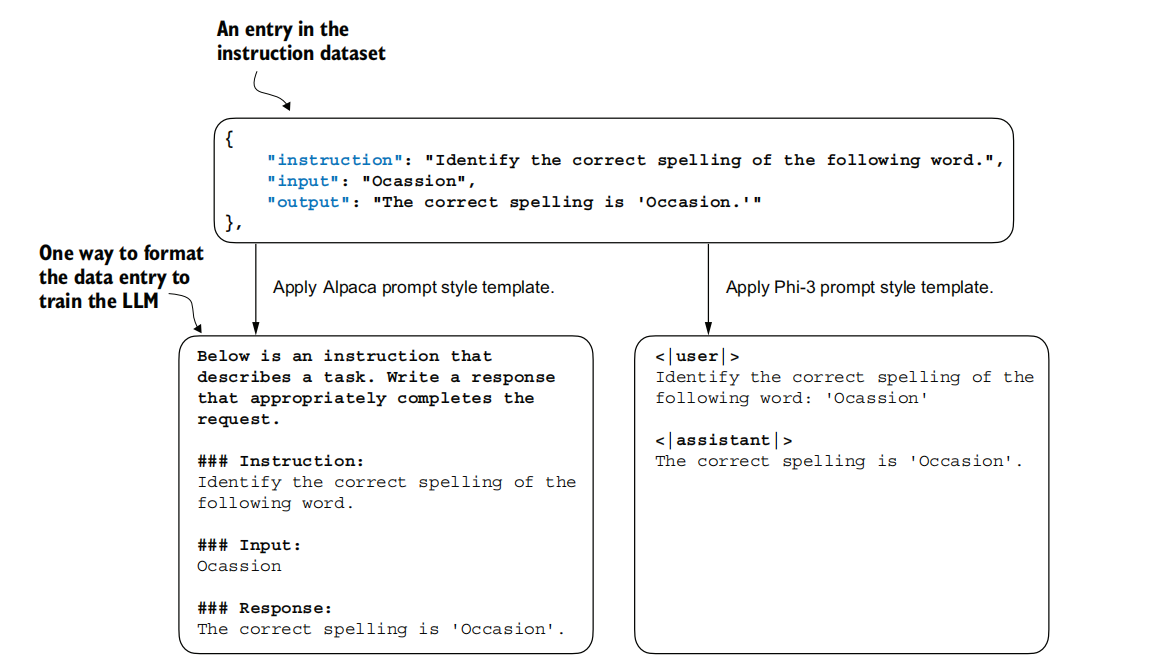

## Implementing the prompt formatting function

In [50]:
def format_input(entry):
    instruction_text = (
    f"Below is an instruction that describes a task. "
    f"Write a response that appropriately completes the request."
    f"\n\n### Instruction:\n{entry['instruction']}"
    )
    
    input_text = (
    f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""
    )
    return instruction_text + input_text

In [51]:
model_input = format_input(data[50])
desired_response = f"\n\n### Response:\n{data[50]['output']}"
print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion

### Response:
The correct spelling is 'Occasion.'


In [52]:
model_input = format_input(data[547])
desired_response = f"\n\n### Response:\n{data[547]['output']}"
print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Generate a question that could logically follow the statement below.

### Input:
I just got a new job.

### Response:
What will you be doing at your new job?


### Partitioning the dataset

In [53]:
train_portion = int(len(data) * 0.85) 
test_portion = int(len(data) * 0.1) 

val_portion = len(data) - train_portion - test_portion 
train_data = data[:train_portion]

test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 935
Validation set length: 55
Test set length: 110


## Organizing data into training batches

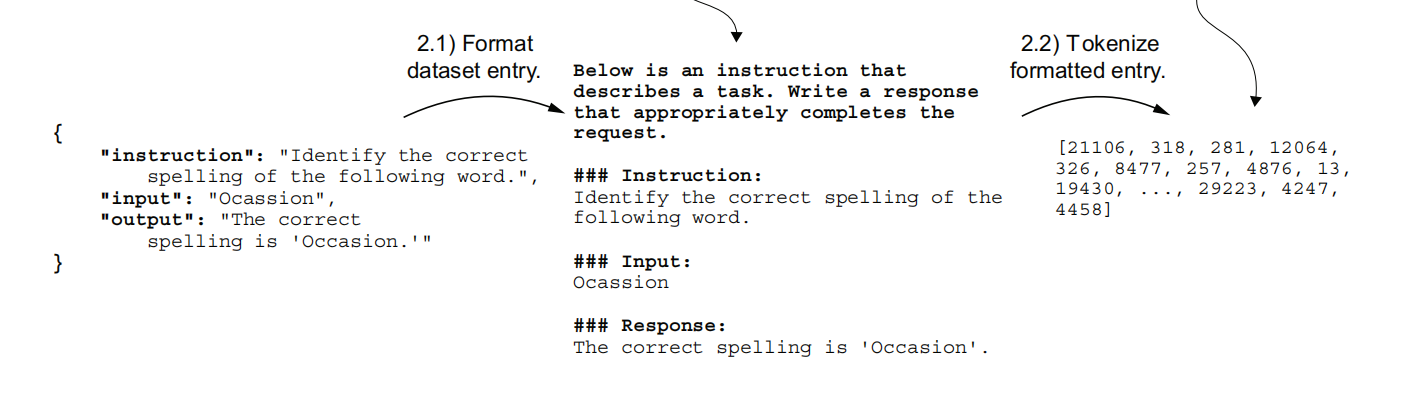

In [54]:
import torch
from torch.utils.data import Dataset
class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.encoded_texts = []
        for entry in data:          # Pretokenizes text
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n### Response:\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(tokenizer.encode(full_text))
    
    def __getitem__(self, index):
        return self.encoded_texts[index]
    
    def __len__(self):
        return len(self.data)

In [55]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


- Custom collate function pads the training examples in each batch to the
same length while allowing different batches to have different lengths.
- This approach minimizes unnecessary padding by only extending
sequences to match the longest one in each batch, not the whole dataset.


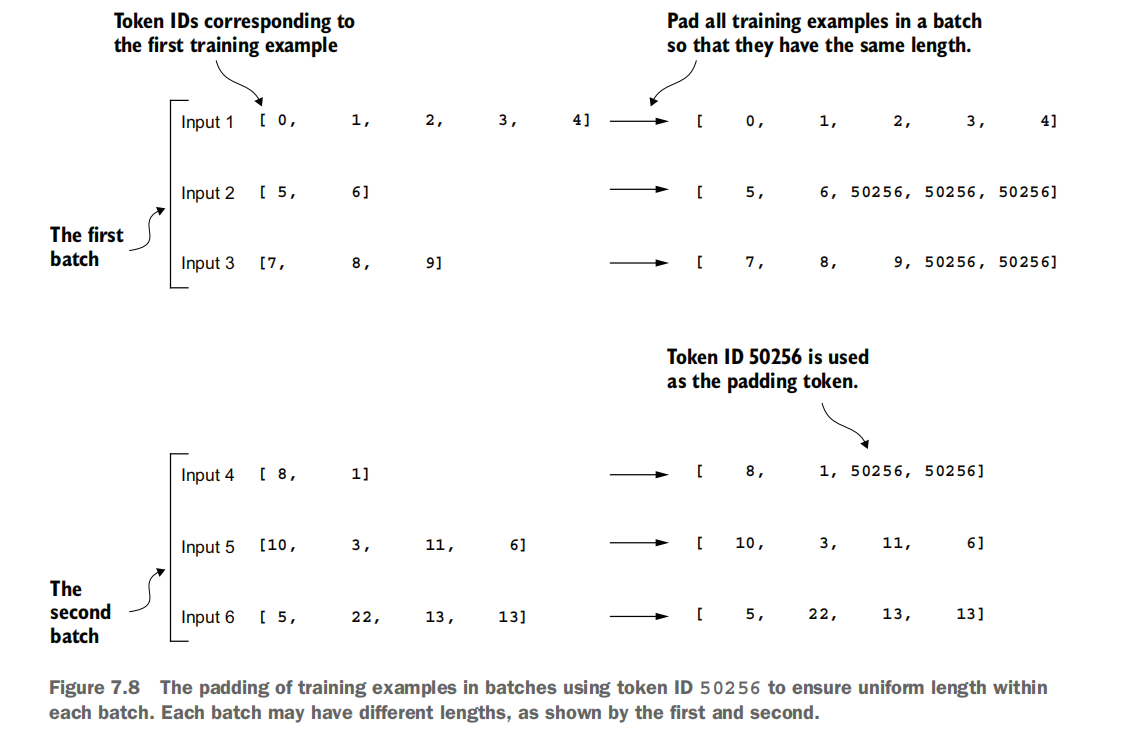

In [56]:
def custom_collate_draft_1(batch, pad_token_id=50256, device="cpu"):
    batch_max_length = max(len(item)+1 for item in batch)   # Finds the longest sequence in the batch
    inputs_lst = []
    for item in batch:      # Pads each sequence to the length of the longest sequence
        new_item = item.copy()
        new_item += [pad_token_id]
        padded = (
        new_item + [pad_token_id] * 
        (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded)   #Removes extra padded token added earlier
        inputs_lst.append(inputs)
    inputs_tensor = torch.stack(inputs_lst).to(device) 
    return inputs_tensor

In [57]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (
 inputs_1,
 inputs_2,
 inputs_3
)
print(custom_collate_draft_1(batch))

tensor([[    0,     1,     2,     3,     4, 50256],
        [    5,     6, 50256, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256, 50256]])


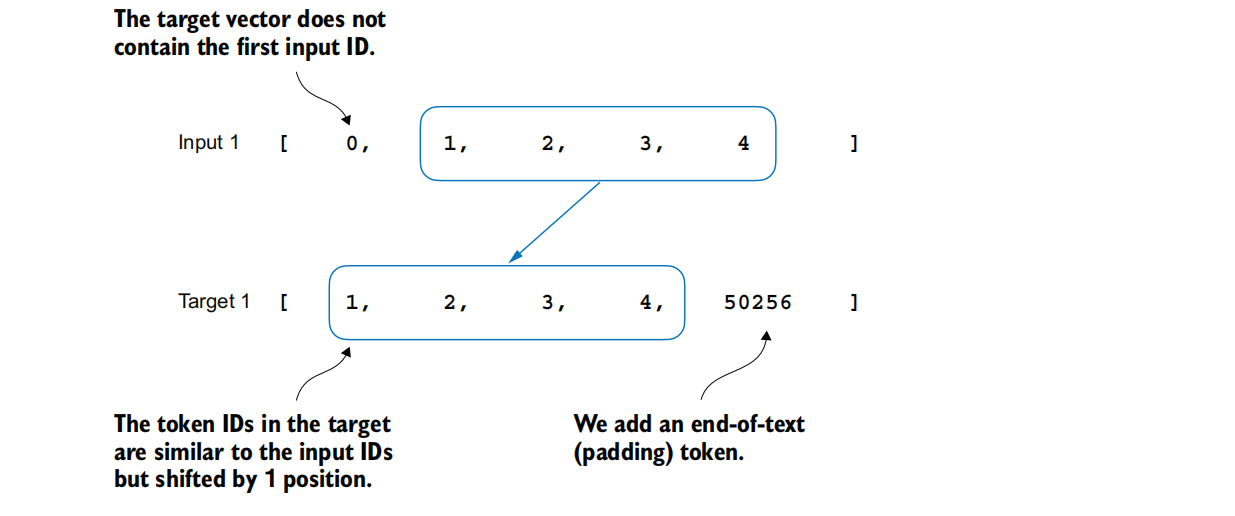
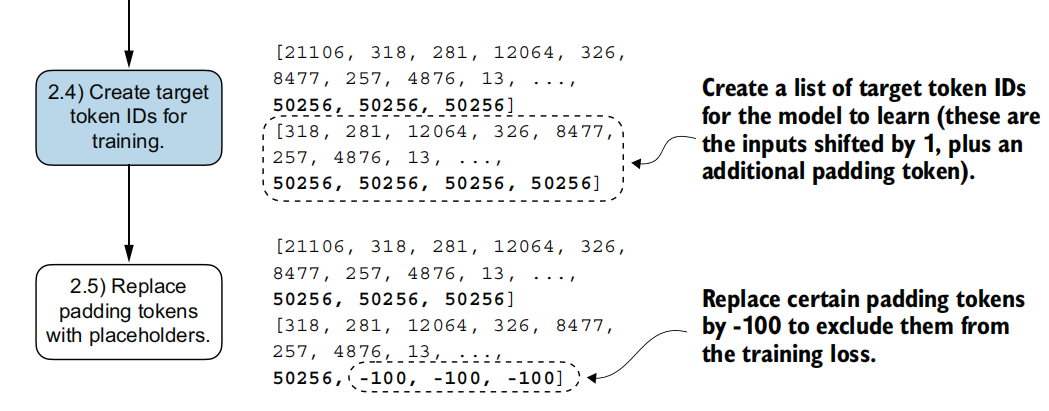

In [58]:
def custom_collate_draft_2(batch, pad_token_id=50256, device="cpu"):
    batch_max_length = max(len(item)+1 for item in batch)
    inputs_lst, targets_lst = [], []
    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]
        padded = (
            new_item + [pad_token_id] * 
            (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1]) 
        targets = torch.tensor(padded[1:]) # Shifts +1 to the right for targets
        
        inputs_lst.append(inputs)
        targets_lst.append(targets)
        
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)
    return inputs_tensor, targets_tensor

inputs, targets = custom_collate_draft_2(batch)
print(f"inputs:\n{inputs}")
print(f"targets:\n {targets}")

inputs:
tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
targets:
 tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256, 50256, 50256, 50256],
        [    8,     9, 50256, 50256, 50256]])


### Placeholder in token-ids
#### We will replace the eos tokens with a placeholder (-100) except the starting eos token for the target tensor

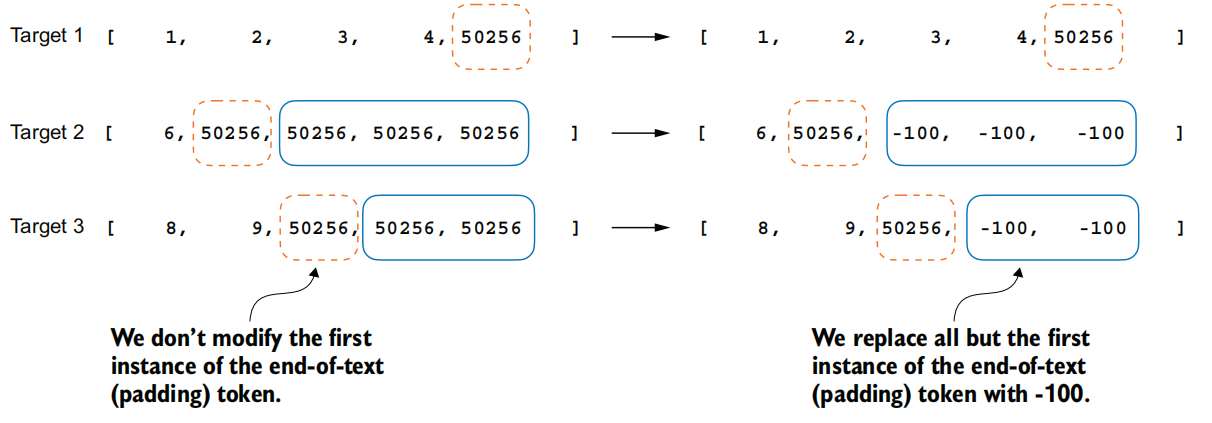

In [59]:
def custom_collate_fn(
 batch,
 pad_token_id=50256,
 ignore_index=-100,
 allowed_max_length=None,
 device="cpu"
):
    batch_max_length = max(len(item)+1 for item in batch)
    inputs_lst, targets_lst = [], []
    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]
        
        padded = ( 
            new_item + [pad_token_id] * 
            (batch_max_length - len(new_item)) 
        )
        inputs = torch.tensor(padded[:-1]) 
        targets = torch.tensor(padded[1:]) 
        
        #Replaces all but the first padding tokens in targets by ignore_index
        mask = targets == pad_token_id 
        indices = torch.nonzero(mask).squeeze() 
        if indices.numel() > 1: 
            targets[indices[1:]] = ignore_index 
        # Optional truncation of inputs and targets
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length] 
            targets = targets[:allowed_max_length] 
        inputs_lst.append(inputs)
        targets_lst.append(targets)
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)
    return inputs_tensor, targets_tensor

In [60]:
inputs, targets = custom_collate_fn(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256,  -100,  -100,  -100],
        [    8,     9, 50256,  -100,  -100]])


## Why -100 ??
Look at the following example

In [61]:
logits_1 = torch.tensor(
 [[-1.0, 1.0], 
 [-0.5, 1.5]] 
)
targets_1 = torch.tensor([0, 1]) # Correct token indices to generate
loss_1 = torch.nn.functional.cross_entropy(logits_1, targets_1)
print(loss_1)

tensor(1.1269)


In [62]:
logits_2 = torch.tensor(
 [[-1.0, 1.0],
 [-0.5, 1.5],
 [-0.5, 1.5]] 
)
targets_2 = torch.tensor([0, 1, 1])
loss_2 = torch.nn.functional.cross_entropy(logits_2, targets_2)
print(loss_2)

tensor(0.7936)


In [63]:
targets_3 = torch.tensor([0, 1, -100])
loss_3 = torch.nn.functional.cross_entropy(logits_2, targets_3)
print(loss_3)
print("loss_1 == loss_3:", loss_1 == loss_3)

tensor(1.1269)
loss_1 == loss_3: tensor(True)


- The default setting of the cross entropy function in PyTorch is cross_entropy(...,
ignore_index=-100). This means that it ignores targets labeled with -100. 
- We take
advantage of this ignore_index to ignore the additional end-of-text (padding) tokens
that we used to pad the training examples to have the same length in each batch.
- However, we want to keep one 50256 (end-of-text) token ID in the targets because it
helps the LLM to learn to generate end-of-text tokens, which we can use as an indicator that a response is complete.

#### We can also mask the instruction part during loss calculation
Research shows that, model performs better without masking the instructions
- Shi
et al., “Instruction Tuning With Loss Over Instructions” (https://arxiv.org/abs/
2405.14394)


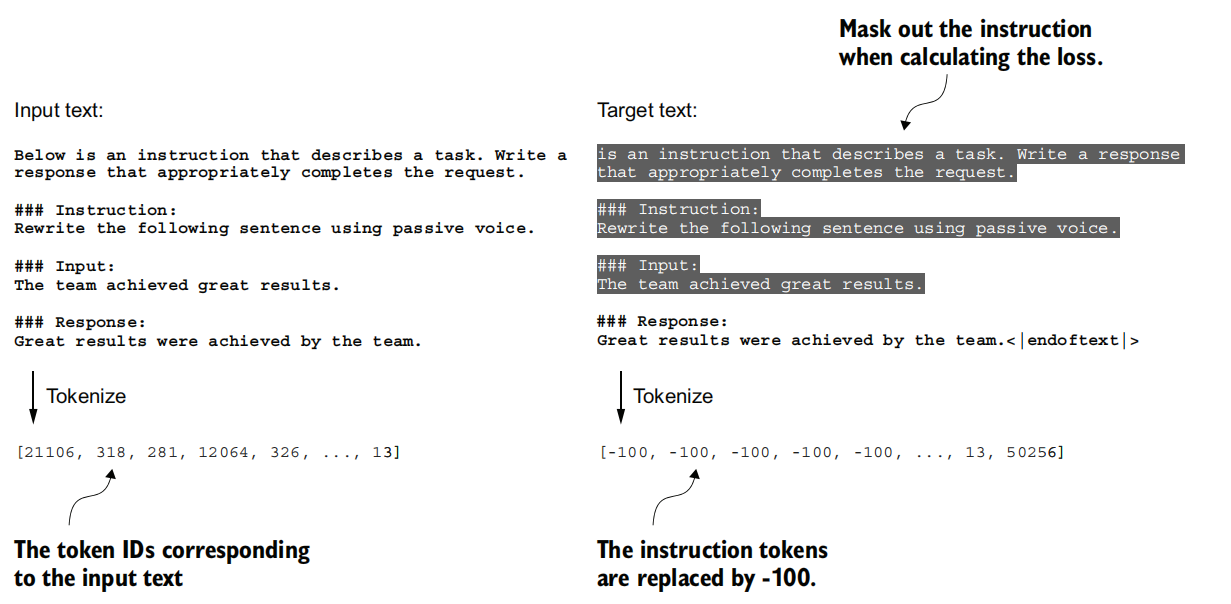

## Creating data loaders for an instruction dataset

In [64]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# if torch.backends.mps.is_available(): 
# device = torch.device("mps")" 
print("Device:", device)

Device: cuda


In [65]:
from functools import partial

customized_collate_fn = partial(
 custom_collate_fn,
 device=device,
 allowed_max_length=1024
)

In [66]:
from torch.utils.data import DataLoader
num_workers = 0 
batch_size = 8

torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer) # dataset class
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)
val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)
test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

In [67]:
print("Train loader:")
for inputs, targets in train_loader:
 print(inputs.shape, targets.shape)

Train loader:


torch.Size([8, 61]) torch.Size([8, 61])
torch.Size([8, 76]) torch.Size([8, 76])
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 72]) torch.Size([8, 72])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 77]) torch.Size([8, 77])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 79]) torch.Size([8, 79])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 66]) torch.Size([8, 66])
torch.Size([8, 83]) torch.Size([8, 83])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 68]) torch.Size([8, 68])


## Loading a pretrained LLM

In [69]:
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"
BASE_CONFIG = {
 "vocab_size": 50257, 
 "context_length": 1024, 
 "drop_rate": 0.0, 
 "qkv_bias": True 
}
model_configs = {
 "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
 "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
 "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
 "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

GPT_CONFIG_124M = {
 "vocab_size": 50257,
 "context_length": 256, # We shorten the context length from 1,024 to 256 tokens. Original GPT-2 has a context length of 1,024 tokens.
 "emb_dim": 768,
 "n_heads": 12,
 "n_layers": 12, 
 "drop_rate": 0.1, 
 "qkv_bias": False
}    

In [72]:
from gpt_download import download_and_load_gpt2, load_weights_into_gpt
from gpt import GPTModel
model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")

settings, params = download_and_load_gpt2(                
        model_size=model_size, models_dir="gpt2"
)


File already exists and is up-to-date: gpt2\124M\checkpoint
File already exists and is up-to-date: gpt2\124M\encoder.json
File already exists and is up-to-date: gpt2\124M\hparams.json
File already exists and is up-to-date: gpt2\124M\model.ckpt.index
File already exists and is up-to-date: gpt2\124M\model.ckpt.meta
File already exists and is up-to-date: gpt2\124M\vocab.bpe
File already exists and is up-to-date: gpt2\124M\model.ckpt.data-00000-of-00001


In [73]:
model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

In [74]:
torch.manual_seed(123)
input_text = format_input(val_data[0])
print(input_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'


In [84]:
from utils import text_to_token_ids, token_ids_to_text
from gpt import generate
token_ids = generate(
    model=model,
    idx=text_to_token_ids(input_text, tokenizer),
    max_new_tokens=35,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256,
)
generated_text = token_ids_to_text(token_ids, tokenizer)

In [85]:
response_text = generated_text[len(input_text):].strip()
print(response_text)

### Instruction:

Convert the active sentence to passive: 'The chef cooks the meal every day.'

### Instruction:

Convert the active


## Fine-tuning the LLM on instruction data